In [1]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML 

Seq2Seq with PyTorch
====

Sequence-to-Sequence (Seq2Seq) learning is a useful class of neural network model to map sequential input into an output sequence. It has been shown to work well on various task, from machine translation to interpreting Python without an interpreter. {{citations-needed}}

This notebook is a hands-on session to write an encoder-decoder Seq2Seq network using PyTorch for [DataScience SG meetup](https://www.meetup.com/DataScience-SG-Singapore/events/246541733/). 


It would be great if you have at least worked through the ["Deep Learning in 60 minutes" PyTorch tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before continuing the rest of the notebook.


Acknowledgements
----
The materials are largely based on the 

 - [intermediate PyTorch tutorials by Sean Robertson](http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) and 
 - [Luong et al. tutorial on neural machine translation in ACL16](https://sites.google.com/site/acl16nmt/home).

The dataset used in this exercise is hosted on https://www.kaggle.com/alvations/sg-kopi

Kopi Problems
====

In this hands-on session, we want to **train a neural network to translate from Singlish Kopi orders to English?**


**"Singlish" -> English**

```
"Kopi" -> Coffee with condensed milk
"Kopi O" -> Coffee without milk or sugar
"Kopi dinosaur gau siew dai peng" -> ???
```

(Image Source: http://www.straitstimes.com/lifestyle/food/get-your-kopi-kick)

In [2]:
Image(url="https://static.straitstimes.com.sg/sites/default/files/160522_kopi.jpg", width=700)

Seriously?
----

Yes, we'll be translating Singlish Kopi orders to English using the [sequence-to-sequence network](https://arxiv.org/abs/1409.3215) {{citations-needed}}. 

But first...
---

Data Munging
====

Before any machine/deep learning, we have to get some data and "hammer" it until we get it into the shape we want.

> *Data scientists spend 60% of their time on cleaning and organizing data. Collecting data sets comes second at 19% of their time, meaning data scientists spend around 80% of their time on preparing and managing data for analysis.*

> (Source: [Gil Press](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#3e4dc0416f63) Forbes article)

**Step 1:** Take the data from somewhere, in this case: http://kaggle.com/alvations/sg-kopi.

**Step 2:** Import your favorite dataframe and text processing library.

**Step 3:** Munge the data till desired.

In [3]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

# Reads the tab-delimited data using Pandas.
kopitiam = pd.read_csv('coffee-culture-sg.tsv', sep='\t')
kopitiam.head()

,Local Terms,Meaning,Source
0,Kopi O,Black Coffee with Sugar,https://daneshd.com/2010/02/28/a-rough-guide-t...
1,Kopi,Black Coffee with Condensed Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
2,Kopi C,Black Coffee with Evaporated Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
3,Kopi Kosong,Black Coffee without sugar or milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
4,Kopi Gah Dai,Black Coffee with extra condensed milk,https://daneshd.com/2010/02/28/a-rough-guide-t...


In [4]:
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
singlish_sents = [START] + kopitiam['Local Terms'].apply(str.lower).apply(word_tokenize) + [END]
english_sents = [START] + kopitiam['Meaning'].apply(str.lower).apply(word_tokenize) + [END]

# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First Singlish sentence:', singlish_sents[0])
print('First English sentence:', english_sents[0])

First Singlish sentence: ['<s>', 'kopi', 'o', '</s>']
First English sentence: ['<s>', 'black', 'coffee', 'with', 'sugar', '</s>']


In [5]:
# Let's convert the individual words into some sort of unique index 
# and use the unique to represent the words. 
## Cut-away: Integers = 1-2 bytes vs UTF-8 Strings = no. of chars * 1-2 bytes. @_@

english_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
english_vocab.add_documents(english_sents)

singlish_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
singlish_vocab.add_documents(singlish_sents)

# First ten words in the vocabulary.
print('First 10 Singlish words:\n', sorted(singlish_vocab.items())[:10])
print()
print('First 10 English words:\n', sorted(english_vocab.items())[:10])

First 10 Singlish words:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, 'kopi'), (4, 'o'), (5, 'c'), (6, 'kosong'), (7, 'dai'), (8, 'gah'), (9, 'siew')]

First 10 English words:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, 'black'), (4, 'coffee'), (5, 'sugar'), (6, 'with'), (7, 'condensed'), (8, 'milk'), (9, 'evaporated')]


In [6]:
# Now, convert all the sentences into list of the indices 
print('First Singlish sentence:', singlish_vocab.doc2idx(singlish_sents[0]) )
print('First English sentence:', english_vocab.doc2idx(english_sents[0]) )

First Singlish sentence: [0, 3, 4, 1]
First English sentence: [0, 3, 4, 6, 5, 1]


In [143]:
# Lets create a function to convert new sentences into the indexed forms.
def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END])

new_kopi = "Kopi dinosaur gau siew dai peng"
vectorize_sent(new_kopi, singlish_vocab)

[0, 3, 22, 11, 9, 7, 12, 1]

In [115]:
# For the last step of data hammering, we need to clobber 
# the vectorized sentence into PyTorch Variable. 
def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    return result.cuda() if use_cuda else result

new_kopi = "Kopi dinosaur gau siew dai peng"
variable_from_sent(new_kopi, singlish_vocab)

Variable containing:
    0
    3
   22
   11
    9
    7
   12
    1
[torch.LongTensor of size 8x1]

In [116]:
# To get the sentence length.
variable_from_sent(new_kopi, singlish_vocab).size()[0] # Includes START and END symbol.

8

In [53]:
# Prepare the whole training corpus.
singlish_tensors = kopitiam['Local Terms'].apply(lambda s: variable_from_sent(s, singlish_vocab))
english_tensors = kopitiam['Meaning'].apply(lambda s: variable_from_sent(s, english_vocab))

sent_pairs = list(zip(singlish_tensors, english_tensors))

The Seq2Seq Model
====

A Recurrent Neural Network (RNN), is a network that operates on a sequence and uses its own output as input for subsequent steps.

> *The general idea is to make **two recurrent neural network transform from one sequence to another**. An encoder network condenses an input sequence into a vector and a decoder netwrok unfolds the vector into a new sequence.*



In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()


The Encoder
====

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.


<img src="http://pytorch.org/tutorials/_images/encoder-network.png" align='left'>

In [58]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        embedded = self.embedding(input).view(1, 1, -1)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result


Simple Decoder
====

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<s>` token, and the first hidden state is the context vector (the encoder’s last hidden state).


<img src="http://pytorch.org/tutorials/_images/decoder-network.png" align='left'>


In [59]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        output = self.embedding(input).view(1, 1, -1)
        # Transform the embedded output with a relu function. 
        output = F.relu(output)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result
        

Training the Model
====

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.



In [101]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 20

def train_one_epoch(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion):
    """
    Function to put the variables, decoder and optimizers to train per epoch.
    """
    encoder_hidden = encoder.initialize_hidden_states()

    # (Re-)Initialize the optimizers, clear all gradients. 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Initialize the length of the PyTorch variables.
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[START_IDX]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == END_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length


In [102]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [103]:
def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    
    training_pairs = [random.choice(sent_pairs) for i in range(n_iters)]
    
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train_one_epoch(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [104]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 7s (- 38m 29s) (100 0%) 2.6505
0m 15s (- 37m 53s) (200 0%) 2.2769
0m 23s (- 38m 20s) (300 1%) 2.1790
0m 31s (- 38m 19s) (400 1%) 1.9496
0m 38s (- 38m 5s) (500 1%) 1.9081
0m 46s (- 38m 12s) (600 2%) 1.8574
0m 54s (- 38m 0s) (700 2%) 1.9087
1m 2s (- 37m 57s) (800 2%) 1.7099
1m 10s (- 37m 51s) (900 3%) 1.4763
1m 18s (- 37m 48s) (1000 3%) 1.4021
1m 26s (- 37m 46s) (1100 3%) 1.2450
1m 34s (- 37m 38s) (1200 4%) 1.2951
1m 41s (- 37m 30s) (1300 4%) 1.1240
1m 49s (- 37m 16s) (1400 4%) 1.0743
1m 57s (- 37m 21s) (1500 5%) 1.1606
2m 6s (- 37m 18s) (1600 5%) 1.1041
2m 14s (- 37m 13s) (1700 5%) 0.8860
2m 22s (- 37m 11s) (1800 6%) 1.0419
2m 30s (- 37m 11s) (1900 6%) 1.0665
2m 38s (- 37m 3s) (2000 6%) 1.1248
2m 47s (- 37m 1s) (2100 7%) 0.7572
2m 55s (- 36m 51s) (2200 7%) 0.7403
3m 2s (- 36m 41s) (2300 7%) 1.1159
3m 10s (- 36m 34s) (2400 8%) 0.9563
3m 20s (- 36m 40s) (2500 8%) 0.6792
3m 27s (- 36m 29s) (2600 8%) 0.8766
3m 36s (- 36m 25s) (2700 9%) 0.6764
3m 44s (- 36m 18s) (2800 9%) 0.8449
3m 52s (-

32m 24s (- 11m 59s) (21900 73%) 0.4618
32m 31s (- 11m 49s) (22000 73%) 0.3104
32m 38s (- 11m 40s) (22100 73%) 0.4553
32m 46s (- 11m 31s) (22200 74%) 0.4734
32m 53s (- 11m 21s) (22300 74%) 0.4470
33m 2s (- 11m 12s) (22400 74%) 0.2663
33m 16s (- 11m 5s) (22500 75%) 0.3754
33m 32s (- 10m 58s) (22600 75%) 0.4359
33m 43s (- 10m 50s) (22700 75%) 0.3947
33m 51s (- 10m 41s) (22800 76%) 0.3269
33m 59s (- 10m 32s) (22900 76%) 0.3110
34m 6s (- 10m 22s) (23000 76%) 0.4278
34m 13s (- 10m 13s) (23100 77%) 0.3666
34m 21s (- 10m 4s) (23200 77%) 0.4850
34m 29s (- 9m 55s) (23300 77%) 0.3342
34m 37s (- 9m 46s) (23400 78%) 0.4602
34m 45s (- 9m 36s) (23500 78%) 0.4955
34m 53s (- 9m 27s) (23600 78%) 0.3511
35m 3s (- 9m 19s) (23700 79%) 0.3852
35m 14s (- 9m 10s) (23800 79%) 0.4021
35m 23s (- 9m 2s) (23900 79%) 0.4050
35m 31s (- 8m 52s) (24000 80%) 0.3765
35m 39s (- 8m 43s) (24100 80%) 0.4599
35m 47s (- 8m 34s) (24200 80%) 0.3084
35m 55s (- 8m 25s) (24300 81%) 0.4676
36m 7s (- 8m 17s) (24400 81%) 0.3272
36m 1

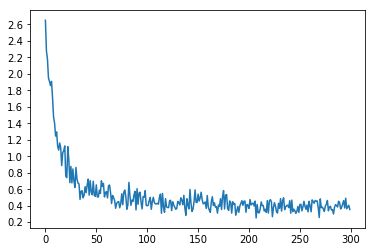

In [224]:
hidden_size = 500

singlish_vocab
encoder1 = EncoderRNN(len(singlish_vocab), hidden_size)
attn_decoder1 = DecoderRNN(hidden_size, len(english_vocab))


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

train(encoder1, attn_decoder1, 30000, print_every=100)

In [ ]:
output_words, attentions = evaluate(encoder, decoder, pair[0])
output_sentence = ' '.join(output_words)

In [156]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(sent_pairs)
        print('>', [singlish_vocab[i] for i in pair[0][0]])
        print('=', [english_gocab[i] for i in pair[1][0]])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = [english_vocab[i] for i in output_words[1:output_words.index(1)]]
        print('<', output_sentence)
        print('')


In [157]:
def evaluate(encoder, decoder, input_variable, max_length=MAX_LENGTH):
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initialize_hidden_states()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[START_IDX]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    
    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == END:
            decoded_words.append('</s>')
            break
        else:
            decoded_words.append(ni)

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words

In [179]:
def translate(kopi_order):
    output_words = evaluate(encoder1, attn_decoder1, variable_from_sent(kopi_order, singlish_vocab))
    output_sentence = [english_vocab[i] for i in output_words[1:output_words.index(1)]]
    return ' '.join(output_sentence)

In [225]:
translate('teh')

'tea with condensed milk'

In [226]:
translate('teh o')

'tea without milk but with sugar'

In [227]:
translate('teh c')

'tea with evaporated milk and sugar instead of condensed milk'

In [228]:
translate('teh ga dai')

'hot tea more condensed'

In [229]:
translate('teh c ga dai')

'hot tea with evaporated milk and more sugar'

In [230]:
translate('teh c ga dai peng')

'iced tea with evaporated milk and sugar'

In [231]:
translate('teh o siew dai')

'tea with less sugar'

In [232]:
translate('teh tiloh')

'heaviest , purest version of tea with no water added at all to the initial brew'

In [233]:
translate('teh tiloh peng')

'iced version of tea'

In [234]:
translate('tak kiu peng')

'iced milo'

In [235]:
translate('michael jackson')

'soya bean milk mixed with grass jelly'

In [236]:
translate('michael jackson peng')

'iced milo'

In [240]:
translate('teh siew dai peng')

'iced tea with condensed'

In [206]:
import pickle

In [241]:
with open('encoder_vanilla_500.pkl', 'wb') as fout:
    pickle.dump(encoder1, fout)
    
with open('decoder_vanilla_500.pkl', 'wb') as fout:
    pickle.dump(attn_decoder1, fout)